In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve,  roc_auc_score
from torch.utils.data import DataLoader, TensorDataset, Dataset,random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingWarmRestarts
import random
import os


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    device = torch.device('cuda')


def plot_ExpTest_hist(test_probs_list,fig_name):
    bins=100
    plt.figure(figsize=(8,6))
    plt.hist(test_probs_list, bins=bins, alpha=0.6,density=True,  label=f"ExpData size: {len(test_probs_list)}")
    plt.xlabel("CNN_2 Output Probability")
    plt.ylabel("Counts")
    plt.legend()
    plt.title(fig_name)
    plt.grid(True, alpha=0.3)
    plt.savefig(f'./figures/{fig_name}.png')
    plt.show()
    plt.close()

def plot_metrics(model,train_loss_list,val_loss_list,train_accs_list,val_accs_list,val_labels_list, val_probs_list):
    fpr, tpr, _ = roc_curve(val_labels_list, val_probs_list)
    roc_auc =safe_roc_auc_score(val_labels_list, val_probs_list)
    fig, ax = plt.subplots(1, 4, figsize=(16, 4),) 
    # 损失曲线
    ax[0].plot(train_loss_list, label=f"Train Loss, last={np.min(train_loss_list):.4f}",)
    ax[0].plot(val_loss_list, label=f"Validation Loss, last={np.min(val_loss_list):.4f}",)
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].set_title(f"{model} Training Loss")
    ax[0].legend()
    ax[0].grid(linestyle='--', linewidth=0.5)
    # 准确率曲线
    ax[1].plot(train_accs_list, label=f"Train accuracy, last={np.max(train_accs_list):.4f}", )
    ax[1].plot(val_accs_list, label=f"Vali accuracy, last={np.max(val_accs_list):.4f}", )
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title(f"{model} Accuracy Curve")
    ax[1].legend()
    ax[1].grid(linestyle='--', linewidth=0.5)
    # 混淆矩阵
    ax[2].plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})", linewidth=2)
    ax[2].plot([0, 1], [0, 1], linestyle="--", color="gray")  
    ax[2].set_xlabel("False Positive Rate (FPR)")
    ax[2].set_ylabel("True Positive Rate (TPR)")
    ax[2].set_title("ROC Curve")
    ax[2].legend()
    ax[2].grid(linestyle='--', linewidth=0.5)
    # 概率分布
    val_probs_list = np.array(val_probs_list)
    val_labels_list = np.array(val_labels_list)
    bkg_pred = val_probs_list[np.where(val_labels_list == 0)]  # 背景概率
    sig_pred = val_probs_list[np.where(val_labels_list == 1)]  # 信号概率
    threshold = 0.8
    sig_ratio = len(sig_pred[sig_pred > threshold]) / len(sig_pred)  # 信号保有率
    bkg_ratio = len(bkg_pred[bkg_pred > threshold]) / len(bkg_pred)  # 背景误判率
    bins = 100
    
    ax[3].hist(sig_pred, bins=bins, range=(0, 1), density=True, histtype='bar', 
               label=f"$N_{{signal}}$={len(sig_pred)}")
    ax[3].hist(bkg_pred, bins=bins, range=(0, 1), density=True, histtype='bar', 
               label=f"$N_{{bkg}}$={len(bkg_pred)}")
    # ax[3].vlines(threshold, 0, 15, linestyle='--', color='red', label=f'threshold={threshold}')
    ax[3].set_xlabel('Softmax output')
    ax[3].set_ylabel('Distribution')
    ax[3].set_title(f'Test Data {model} Output')
    ax[3].legend(loc="upper center")
    ax[3].grid(linestyle="dashed", linewidth=0.5)
    # ax[3].set_ylim(0, 20)  # 调整 y 轴范围以适应文本框
    print(f'when t>{threshold}, 信号保有率={sig_ratio:.5f}, 背景误判率={bkg_ratio:.5f}')
    print(f'when t>{threshold}, Nsig/(Nsig+Nbkg)={sig_ratio/(sig_ratio+bkg_ratio):.4f}, Nsig : Nbkg={sig_ratio/bkg_ratio:.4f}')
 
    plt.tight_layout()
    plt.savefig(f'./figures/{model}_Metrics.png', dpi=300)
    plt.show()
    plt.close()

class CNNClassifier(nn.Module):
    def __init__(self, only_ED=False, img_size=128):
        super(CNNClassifier, self).__init__()
        self.img_size = img_size
        n=1 if only_ED else 2
        self.model = nn.Sequential(
            nn.Conv2d(n, 16, kernel_size=3, padding=1),  # Conv 1: 输入通道从 1 改为 2
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Conv 2
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv 3
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),

            nn.Flatten(),
            nn.Linear(64 * (self.img_size // 8) * (self.img_size // 8), 128),  # Fully Connected Layer
            nn.ReLU(),
            nn.Dropout(0.3),  # 50% 概率丢弃神经元
            nn.Linear(128, 2),  # 2 分类（monopole vs background）
            # nn.Softmax(dim=1)  # 如果需要概率输出，可以取消注释
        )

    def forward(self, x):
        return self.model(x)

def hits_to_image(hE, hM, grid_size=128, array_radius=640.0,only_ED=False):
    grid_size = int(grid_size)
    bins = np.linspace(-array_radius, array_radius, grid_size + 1)
    image_em = np.zeros((grid_size, grid_size))
    image_mu = np.zeros((grid_size, grid_size))
    
    # Electromagnetic channel
    if len(hE) > 0:
        x, y, pe = hE[:, 0], hE[:, 1], hE[:, 2]
        image_em, _, _ = np.histogram2d(x, y, bins=[bins, bins], weights=pe)
        image_em = image_em.T  # [grid_size, grid_size]
        # if image_em.max() > 0:
        #     image_em = image_em / image_em.max()
    
    # Muon channel
    if len(hM) > 0:
        x, y, pe = hM[:, 0], hM[:, 1], hM[:, 2]
        image_mu, _, _ = np.histogram2d(x, y, bins=[bins, bins], weights=pe)
        image_mu = image_mu.T
        # if image_mu.max() > 0:
        #     image_mu = image_mu / image_mu.max()
    
    # Stack into 2 channels
    if only_ED:
        return np.expand_dims(image_em, axis=0)
    else:
        image = np.stack([image_em, image_mu], axis=0)  # [2, grid_size, grid_size]
        return image

class AirShowerDataset(Dataset):
    def __init__(self, hitsE, hitsM, labels, grid_size=128, only_ED=False):
        self.hitsE = hitsE
        self.hitsM = hitsM
        self.labels = labels
        self.grid_size = grid_size
        self.only_ED = only_ED
   
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        hE = self.hitsE[idx]
        hM = self.hitsM[idx]
        label = self.labels[idx]
        image = hits_to_image(hE, hM, self.grid_size, only_ED=self.only_ED)
        image_tensor = torch.tensor(image, dtype=torch.float32)  # [2, grid_size, grid_size]
        return image_tensor, torch.tensor(label, dtype=torch.long)


class CNNClassifier_new(nn.Module):
    def __init__(self, num_classes=2, grid_size=128, only_ED=False):
        n=1 if only_ED else 2
        super(CNNClassifier_new, self).__init__()
        self.conv1 = nn.Conv2d(n, 64, kernel_size=3, padding=1)  # 2 input channels
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * (grid_size // 8) * (grid_size // 8), 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



def CNN_exp_test(exp_npz, label):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 获取CPU核心数，动态设置workers
    num_workers = min(os.cpu_count() - 2, 30)  # 留出2个核心给系统，最多8个
    
    data = np.load(exp_npz, allow_pickle=True)
    hitsE = data['hitsE']
    hitsM = data['hitsM']
    labels = data['labels']
    
    exp_dataset = AirShowerDataset(hitsE, hitsM, labels, grid_size=128)
    
    # 优化DataLoader配置
    test_loader = DataLoader(
        exp_dataset, 
        batch_size=128,  # 增加批次大小以提高GPU利用率
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True,  # 启用内存固定，加速CPU到GPU的数据传输
        persistent_workers=True if num_workers > 0 else False  # 保持worker进程
    )
    
    model = CNNClassifier_new(num_classes=2).to(device)
    if torch.cuda.device_count() > 1:
        print(f"使用 {torch.cuda.device_count()} 个GPU进行并行推理")
        model = nn.DataParallel(model)
    
    model_file = "./models/best_cnn_model_new_loss-coswarmre.pt"
        # 修复权重加载
    state_dict = torch.load(model_file, map_location=device, weights_only=True)
    
    # 处理键名不匹配问题
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    
    # 如果当前模型是DataParallel但权重是单GPU的，需要添加'module.'前缀
    if isinstance(model, nn.DataParallel):
        for k, v in state_dict.items():
            if not k.startswith('module.'):
                name = 'module.' + k  # 添加'module.'前缀
            else:
                name = k
            new_state_dict[name] = v
    else:
        # 如果当前模型是单GPU但权重是DataParallel的，需要移除'module.'前缀
        for k, v in state_dict.items():
            if k.startswith('module.'):
                name = k[7:]  # 移除'module.'前缀
            else:
                name = k
            new_state_dict[name] = v
    
    # 加载修复后的权重
    model.load_state_dict(new_state_dict)
    # model.load_state_dict(torch.load(model_file, map_location=device))
    print(f'实验数据集加载完成, 开始使用CNN分类\n使用模型为: {model_file}')
    print(f'使用设备: {device}, Workers: {num_workers}, 批次大小: 128')

    # 启用benchmark模式（如果输入尺寸固定）
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.benchmark = True

    model.eval()
    val_preds_list, val_labels_list, val_probs_list = [], [], []
    
    # 使用torch.inference_mode()替代torch.no_grad()，性能更好
    with torch.inference_mode():
        for images, labels_batch in test_loader:
            images = images.to(device, non_blocking=True)  # 非阻塞传输
            
            # 使用混合精度推理（如果GPU支持）
            with torch.cuda.amp.autocast():
                out = model(images)
            
            val_probs = F.softmax(out, dim=1).cpu().numpy()
            val_preds = torch.argmax(out, dim=1).cpu().numpy()
            
            val_preds_list.extend(val_preds)
            val_labels_list.extend(labels_batch.cpu().numpy())
            val_probs_list.extend(val_probs[:, 1])

    plot_ExpTest_hist(val_probs_list, fig_name=label)
    
    # 清理内存
    del model, test_loader, exp_dataset
    torch.cuda.empty_cache()

def old_train():
    data=np.load("./Dataset_Filted/ForTrain/train_dataset.npz", allow_pickle=True)
    hitsE=data['hitsE']
    hitsM=data['hitsM']
    labels=data['labels']

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Create datasets
    full_dataset = AirShowerDataset(hitsE, hitsM, labels, grid_size=128)
    train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
    print(f"Train set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

    # Model, optimizer, scheduler
    model_file="./models/best_cnn_model_new_loss.pt"
    try:
        if os.path.exists(model_file):
            # 加载模型
            model = CNNClassifier_new(num_classes=2).to(device)
            model.load_state_dict(torch.load(model_file, map_location=device))
            model.eval()
            print(f"成功从 {model_file} 加载模型")
            val_preds_list, val_labels_list, val_probs_list,total_loss = [], [], [],0
            with torch.no_grad():
                for images, labels_batch in val_loader:
                    images = images.to(device)
                    labels_batch = labels_batch.to(device)
                    out = model(images)
                    loss = F.cross_entropy(out, labels_batch)
                    val_probs = F.softmax(out, dim=1).cpu().numpy()
                    val_preds = torch.argmax(out, dim=1).cpu().numpy()
                    val_preds_list.extend(val_preds)
                    val_labels_list.extend(labels_batch.cpu().numpy())
                    val_probs_list.extend(val_probs[:, 1])
                    total_loss += loss.item()
            val_loss = total_loss / len(val_loader)
            val_acc = accuracy_score(val_labels_list, val_preds_list)
            best_auc = roc_auc_score(val_labels_list, val_probs_list) if len(set(val_labels_list)) > 1 else 0.0
            best_loss = val_loss
            print(f"primary model: loss: {best_loss:.4f}, accuracy: {val_acc:.4f}, AUC: {best_auc:.4f}")
            # plot_output_hist(model, val_loader)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        else:
            raise FileNotFoundError(f"模型文件 {model_file} 不存在")     
    except Exception as e:
        print(f"加载模型失败: {e}")
        print("创建新模型实例")
        # 创建新模型
        model = CNNClassifier_new(num_classes=2).to(device)
        best_auc = 0
        best_loss = float('inf')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    
    # >>>>>>>>>>>>>>>>>>>>Training loop<<<<<<<<<<<<<<<<<<<<<
    train_losses, val_losses, train_accs, val_accs, val_aucs = [], [], [], [], []
    patience = 20
    epochs_no_improve = 0
    num_epochs = 50

    def get_lr(optimizer):
        return optimizer.param_groups[0]['lr']

    print("开始训练：")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_preds, train_labels_list = [], []
        for images, labels_batch in train_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            out = model(images)
            loss = F.cross_entropy(out, labels_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(out, dim=1).cpu().numpy()
            train_preds.extend(preds)
            train_labels_list.extend(labels_batch.cpu().numpy())
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(train_labels_list, train_preds)

        model.eval()
        val_preds_list, val_labels_list,val_probs_list, val_loss_total = [], [],[], 0
        with torch.no_grad():
            for images, labels_batch in val_loader:
                images, labels_batch = images.to(device), labels_batch.to(device)
                out = model(images)
                loss = F.cross_entropy(out, labels_batch)
                val_loss_total += loss.item()
                val_probs = F.softmax(out, dim=1).cpu().numpy()

                val_preds = torch.argmax(out, dim=1).cpu().numpy()
                val_preds_list.extend(val_preds)
                val_labels_list.extend(labels_batch.cpu().numpy())
                val_probs_list.extend(val_probs[:, 1])
        val_loss = val_loss_total / len(val_loader)

        val_acc = accuracy_score(val_labels_list, val_preds_list)
        auc = roc_auc_score(val_labels_list, val_probs_list) if len(set(val_labels_list)) > 1 else 0.0

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_aucs.append(auc)


        # scheduler.step(auc)
        # if auc > best_auc:
        #     best_auc = auc
        #     epochs_no_improve = 0
        #     torch.save(model.state_dict(), model_file)
        # else:
        #     epochs_no_improve += 1
        
        scheduler.step(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_file)
        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, ")
        print(f"    Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}, ")
        print(f"    Val AUC: {auc:.4f}, LR: {get_lr(optimizer):.6f}")

        if epochs_no_improve >= patience: 
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Final evaluation
    model.load_state_dict(torch.load(model_file))
    model.eval()
    val_preds_list, val_labels_list, val_probs_list = [], [], []
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images = images.to(device)
            out = model(images)
            val_probs = F.softmax(out, dim=1).cpu().numpy()
            val_preds = torch.argmax(out, dim=1).cpu().numpy()
            val_preds_list.extend(val_preds)
            val_labels_list.extend(labels_batch.cpu().numpy())
            val_probs_list.extend(val_probs[:, 1])

    val_acc = accuracy_score(val_labels_list, val_preds_list)
    auc = roc_auc_score(val_labels_list, val_probs_list) if len(set(val_labels_list)) > 1 else 0.0
    print("Training complete. Final validation metrics:")
    print(f"Accuracy: {val_acc:.4f}, AUC: {auc:.4f}")

    # print(train_losses, val_losses, train_accs, val_accs, val_labels_list, val_probs_list)
    plot_metrics("CNN",train_losses, val_losses,train_accs, val_accs, val_labels_list, val_probs_list)
    
    # # 额外：绘制输出直方图
    # plot_output_hist(model, val_loader)


def setup(rank, world_size):
    """设置分布式训练"""
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()


def safe_roc_auc_score(labels, probs):
   
    labels = np.array(labels)
    probs  = np.array(probs, dtype=np.float64)

    # 去除 NaN
    mask = ~np.isnan(probs)
    labels = labels[mask]
    probs  = probs[mask]

    # 如果类别数小于 2，无法算 AUC
    if len(np.unique(labels)) < 2:
        return 0.0

    try:
        return roc_auc_score(labels, probs)
    except Exception:
        return 0.0

def train_model(dataset_file,model_file, only_ED=False):

    
    # 加载数据
    data = np.load(dataset_file, allow_pickle=True)
    hitsE = data['hitsE']
    hitsM = data['hitsM']
    labels = data['labels']

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    world_size = torch.cuda.device_count()
    
    print(f"可用GPU数量: {world_size}")
    
    # 创建数据集
    full_dataset = AirShowerDataset(hitsE, hitsM, labels, grid_size=128, only_ED=only_ED)
    train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
    
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")

    # 优化数据加载器配置
    num_workers = min(25, os.cpu_count() - 2) if os.cpu_count() else 4
    pin_memory = torch.cuda.is_available()
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=256 * world_size if world_size > 1 else 128,  # 根据GPU数量调整批次大小
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=num_workers > 0
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=256 * world_size if world_size > 1 else 256,
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=num_workers > 0
    )

    # 模型初始化
    
    model = CNNClassifier_new(num_classes=2, only_ED=only_ED)
    # model = CNNClassifier(only_ED=only_ED)

    best_auc = 0
    best_loss = float('inf')
    start_epoch = 0

    # 检查是否有预训练模型
    if os.path.exists(model_file):
        try:
            state_dict = torch.load(model_file, map_location='cpu', weights_only=True)
            
            # 处理可能的键名不匹配（单GPU vs 多GPU）
            from collections import OrderedDict
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                if k.startswith('module.'):
                    name = k[7:]  # 移除'module.'前缀
                else:
                    name = k
                new_state_dict[name] = v
            
            model.load_state_dict(new_state_dict)
            model = model.to(device)
            print(f"成功从 {model_file} 加载模型")
            
            # 验证加载的模型性能
            model.eval()
            val_preds_list, val_labels_list, val_probs_list, total_loss = [], [], [], 0
            
            with torch.no_grad():
                for images, labels_batch in val_loader:
                    images = images.to(device, non_blocking=True)
                    labels_batch = labels_batch.to(device)
                    
                    with autocast():
                        out = model(images)
                        loss = F.cross_entropy(out, labels_batch)
                    
                    val_probs = F.softmax(out, dim=1).cpu().numpy()
                    val_preds = torch.argmax(out, dim=1).cpu().numpy()
                    
                    val_preds_list.extend(val_preds)
                    val_labels_list.extend(labels_batch.cpu().numpy())
                    val_probs_list.extend(val_probs[:, 1])
                    total_loss += loss.item()
            
            val_loss = total_loss / len(val_loader)
            val_acc = accuracy_score(val_labels_list, val_preds_list)
            
            best_auc = safe_roc_auc_score(val_labels_list, val_probs_list)
        
            best_loss = val_loss
            
            print(f"初始模型性能 - 损失: {best_loss:.4f}, 准确率: {val_acc:.4f}, AUC: {best_auc:.4f}")
            
        except Exception as e:
            print(f"加载模型失败: {e}, 创建新模型")
    else:
        print(f"创建新模型实例: {model_file}")

    # 移动到设备并启用多GPU
    model = model.to(device)
    if world_size > 1:
        print(f"使用 {world_size} 个GPU进行训练")
        model = nn.DataParallel(model)
    
    # 优化器和学习率调度器
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=4e-4)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8,)
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,          # 初始周期长度（步数）
        T_mult=1,        # 周期长度不变
        eta_min=1e-7,     # 学习率最小值
        last_epoch=-1
    )
    # 混合精度训练
    scaler = GradScaler() if torch.cuda.is_available() else None

    # 训练循环
    patience = 25
    epochs_no_improve = 0
    num_epochs = 100
    
    train_losses, val_losses, train_accs, val_accs, val_aucs = [], [], [], [], []

    print("开始训练...")
    for epoch in range(start_epoch, num_epochs):
        # 训练阶段
        model.train()
        total_loss = 0
        train_preds, train_labels_list = [], []
        
        for batch_idx, (images, labels_batch) in enumerate(train_loader):
            images = images.to(device, non_blocking=True)
            
            labels_batch = labels_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # 混合精度训练
            with autocast(enabled=scaler is not None):
                out = model(images)
                loss = F.cross_entropy(out, labels_batch)
            
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            scheduler.step(epoch + batch_idx / len(train_loader))

            total_loss += loss.item()
            preds = torch.argmax(out, dim=1).cpu().numpy()
            train_preds.extend(preds)
            train_labels_list.extend(labels_batch.cpu().numpy())
        
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(train_labels_list, train_preds)
        
        # 验证阶段
        model.eval()
        val_preds_list, val_labels_list, val_probs_list, val_loss_total = [], [], [], 0
        
        with torch.no_grad():
            for images, labels_batch in val_loader:
                images = images.to(device, non_blocking=True)
                labels_batch = labels_batch.to(device, non_blocking=True)
                
                with autocast(enabled=scaler is not None):
                    out = model(images)
                    loss = F.cross_entropy(out, labels_batch)
                
                val_loss_total += loss.item()
                val_probs = F.softmax(out, dim=1).cpu().numpy()
                val_preds = torch.argmax(out, dim=1).cpu().numpy()
                
                val_preds_list.extend(val_preds)
                val_labels_list.extend(labels_batch.cpu().numpy())
                val_probs_list.extend(val_probs[:, 1])
        
        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(val_labels_list, val_preds_list)
        auc = safe_roc_auc_score(val_labels_list, val_probs_list)
        
        # 更新学习率
        # scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_loss < best_loss:
            best_loss = val_loss
            best_auc = auc
            epochs_no_improve = 0
            
            # 保存模型（如果是多GPU，先获取module）
            if isinstance(model, nn.DataParallel):
                torch.save(model.module.state_dict(), model_file)
            else:
                torch.save(model.state_dict(), model_file)
            
            print(f"✅ 保存最佳模型，验证损失: {val_loss:.4f}, AUC: {auc:.4f}")
        else:
            epochs_no_improve += 1
        
        # 记录指标
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_aucs.append(auc)
        
        # 打印进度
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"   训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}")
        print(f"   验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}")
        print(f"   AUC: {auc:.4f}, 学习率: {current_lr:.2e}")
        print(f"   最佳损失: {best_loss:.4f}, 无改善轮次: {epochs_no_improve}/{patience}")
        
        # 早停检查
        if epochs_no_improve >= patience:
            print(f"🚨 早停触发于第 {epoch+1} 轮")
            break
    
    # 最终评估
    print("训练完成，加载最佳模型进行最终评估...")
    
    # model = model.to(device)

    # state_dict = torch.load(model_file, map_location=device)
    # model.load_state_dict(state_dict)
    model.eval()
    
    val_preds_list, val_labels_list, val_probs_list = [], [], []
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images = images.to(device, non_blocking=True)
            
            with autocast(enabled=scaler is not None):
                out = model(images)
            
            val_probs = F.softmax(out, dim=1).cpu().numpy()
            val_preds = torch.argmax(out, dim=1).cpu().numpy()
            val_preds_list.extend(val_preds)
            val_labels_list.extend(labels_batch.cpu().numpy())
            val_probs_list.extend(val_probs[:, 1])
    
    val_acc = accuracy_score(val_labels_list, val_preds_list)
    # auc = roc_auc_score(val_labels_list, val_probs_list) if len(set(val_labels_list)) > 1 else 0.0
   
    auc = safe_roc_auc_score(val_labels_list, val_probs_list)
    print("最终验证性能:")
    print(f"   准确率: {val_acc:.4f}")
    print(f"   AUC: {auc:.4f}")
    print(f"   最佳验证损失: {best_loss:.4f}")
    for threshold in [0.8, 0.9, 0.95, 0.99]:
        print(f"   Output>{threshold}: bkg: {len([p for id,p in enumerate(val_probs_list) if val_labels_list[id]==0 and p > threshold])/len([p for id,p in enumerate(val_probs_list) if val_labels_list[id]==0]):.4f}, sig: {len([p for id,p in enumerate(val_probs_list) if val_labels_list[id]==1 and p > threshold])/len([p for id,p in enumerate(val_probs_list) if val_labels_list[id]==1]):.4f}")
  
    # 绘制训练曲线
    plot_metrics("CNN_Optimized", train_losses, val_losses, train_accs, val_accs, val_labels_list, val_probs_list)
    
    # 清理GPU内存
    torch.cuda.empty_cache()



def merge_npzdataset(infile_list,sample_num,outfile=None,):
    if len(infile_list)!=len(sample_num):
        print("The length of infile_list and sample_num must be the same")
        raise ValueError
    data_list = [np.load(file, allow_pickle=True) for file in infile_list]
    merged_hitsE = []
    merged_hitsM = []
    merged_labels = []
    for n,data in enumerate(data_list):
        hitsE = data['hitsE']
        hitsM = data['hitsM']
        labels = data['labels']
        if sample_num[n] == -1: # if sample_num is -1, use all events
            merged_hitsE.extend(hitsE)
            merged_hitsM.extend(hitsM)
            merged_labels.extend(labels)
            print(f"Using all events (size={len(labels)}) from file {infile_list[n]}")
        elif sample_num[n] > 0:
            sample_size= min(len(labels), sample_num[n])
            sample_indices = np.random.choice(len(labels), sample_size, replace=False)
            merged_hitsE.extend(hitsE[sample_indices])
            merged_hitsM.extend(hitsM[sample_indices])
            merged_labels.extend(labels[sample_indices])
            print(f"Using {sample_size} events from file {infile_list[n]}")
        else:
            print(f"Invalid sample_num {sample_num[n]} for file {infile_list[n]}")
            raise ValueError
        
    
    merged_hitsE = np.array(merged_hitsE, dtype=object)  # dtype=object to handle variable-length events
    merged_hitsM = np.array(merged_hitsM, dtype=object)
    merged_labels = np.array(merged_labels, dtype=np.int8)  # Assuming labels are integers (e.g., 0=background, 1=signal)
    if outfile is not None:
        np.savez(outfile, hitsE=merged_hitsE, hitsM=merged_hitsM, labels=merged_labels)
        print(f"Merged {len(merged_labels)} events from {len(infile_list)} files into {outfile}.")
    else:
        print(f"Merged {len(merged_labels)} events from {len(infile_list)} files.")
        return merged_hitsE, merged_hitsM, merged_labels

def pre_loadDataset4Train(inputfilelist,outputfile,sample_num=None):
    
    if sample_num is None:
        sample_num = [-1]*len(inputfilelist)
    if len(inputfilelist) != len(sample_num):
        print("inputfilelist and sample_num should have the same length")
        raise ValueError
    
    hitsE, hitsM, parID = merge_npzdataset(inputfilelist,sample_num=tuple(sample_num))
    labels = np.copy(parID)
    labels[labels == 1] = 0
    labels[labels == 14] = 0
    labels[labels == 43] = 1
    np.savez(outputfile, hitsE=hitsE, hitsM=hitsM, labels=labels)
    print(f"Saved {len(labels)} events to {outputfile}.")

def plot_output_hist(dataset_file, model_file, output_file='/home/zhonghua/Filt_Event/figures/CNN_2_output_hist.png'):
    # 加载数据
    data = np.load(dataset_file, allow_pickle=True)
    hitsE = data['hitsE']
    hitsM = data['hitsM']
    labels = data['labels']

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    world_size = torch.cuda.device_count()
    
    print(f"可用GPU数量: {world_size}")
    
    # 创建数据集
    full_dataset = AirShowerDataset(hitsE, hitsM, labels, grid_size=128)
    train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
    
    print(f"训练集大小: {len(train_dataset)}, 验证集大小: {len(val_dataset)}")

    # 优化数据加载器配置
    num_workers = min(25, os.cpu_count() - 2) if os.cpu_count() else 4
    pin_memory = torch.cuda.is_available()
    
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=256 * world_size if world_size > 1 else 256,
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=num_workers > 0
    )

        
    model = CNNClassifier_new(num_classes=2)
    # if world_size > 1:  # 或者干脆始终加 DataParallel
    #     model = nn.DataParallel(model)

    state_dict = torch.load(model_file, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()


    val_preds_list, val_labels_list, val_probs_list = [], [], []
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images = images.to(device)
            out = model(images)
            val_probs = F.softmax(out, dim=1).cpu().numpy()
            val_preds = torch.argmax(out, dim=1).cpu().numpy()
            val_preds_list.extend(val_preds)
            val_labels_list.extend(labels_batch.cpu().numpy())
            val_probs_list.extend(val_probs[:, 1])
    val_acc = accuracy_score(val_labels_list, val_preds_list)
    auc = roc_auc_score(val_labels_list, val_preds_list) if len(set(val_labels_list)) > 1 else 0.0
    print("Training complete. Final validation metrics:")
    print(f"Accuracy: {val_acc:.4f}, AUC: {auc:.4f}")

    val_labels_list = torch.tensor(val_labels_list).numpy()
    val_preds_list = torch.tensor(val_preds_list).numpy()
    val_probs_list = torch.tensor(val_probs_list).numpy()

    # 分信号与背景分别画 hist
    bins=100
    plt.figure(figsize=(8,6))
    plt.hist(val_probs_list[val_labels_list==1], bins=bins, alpha=0.6,density=True,  label=f"Signal (label=1): {len(val_preds_list[val_labels_list==1])}")
    plt.hist(val_probs_list[val_labels_list==0], bins=bins, alpha=0.6, density=True, label=f"Background (label=0): {len(val_preds_list[val_labels_list==0])}")
    plt.xlabel("CNN_2 Output Probability")
    plt.ylabel("Counts")
    plt.legend()
    plt.title("CNN_2 Classification Output")
    plt.grid(True, alpha=0.3)
    plt.savefig(output_file)
    plt.show()


def pre_loadDataset4Train_filted(npzfiles,csvfiles,outfile, sample_num=-1):
    import pandas as pd
    def params_filter(csvdata:pd.DataFrame):
        R_ue=(-np.inf, -5.11)
        NpE1=(50, np.inf)
        # R_mean=()
        # (csvdata["R_mean"] > R_mean[0]) & (csvdata["R_mean"] < R_mean[1]) &
        indexs = csvdata[(csvdata["R_ue"] > R_ue[0]) & (csvdata["R_ue"] < R_ue[1]) & (csvdata["NpE1"] > NpE1[0]) & (csvdata["NpE1"] < NpE1[1])].index
        return indexs

    if len(npzfiles) != len(csvfiles):
        print("npzfiles and csvfiles should have the same length")
        raise ValueError
    
    all_hitsE, all_hitsM, all_labels = [], [], []
    size=0
    for i in range(len(npzfiles)):
        csvdata=pd.read_csv(csvfiles[i])
        size=size+len(csvdata)
        indexs=params_filter(csvdata)
        npzdata = np.load(npzfiles[i], allow_pickle=True)
        hitsE, hitsM, labels = npzdata["hitsE"], npzdata["hitsM"], npzdata["labels"]
        hitsE_sel = hitsE[indexs]
        hitsM_sel = hitsM[indexs]
        labels_sel = labels[indexs]

        all_hitsE.extend(hitsE_sel)
        all_hitsM.extend(hitsM_sel)
        all_labels.extend(labels_sel)

    all_hitsE = np.array(all_hitsE, dtype=object) 
    all_hitsM = np.array(all_hitsM, dtype=object)
    all_labels = np.array(all_labels, dtype=np.int8)
    print(f"Total number of samples: {size}, filterd: {len(all_labels)}")

    if sample_num != -1 and sample_num < len(all_labels):
        choice = np.random.choice(len(all_labels), sample_num, replace=False)
        all_hitsE = all_hitsE[choice]
        all_hitsM = all_hitsM[choice]
        all_labels = all_labels[choice]
        
    
    
    np.savez_compressed(outfile, hitsE=all_hitsE, hitsM=all_hitsM, labels=all_labels)
    print(f"Saved {len(all_labels)} samples to {outfile}")



Event -1, label: 0


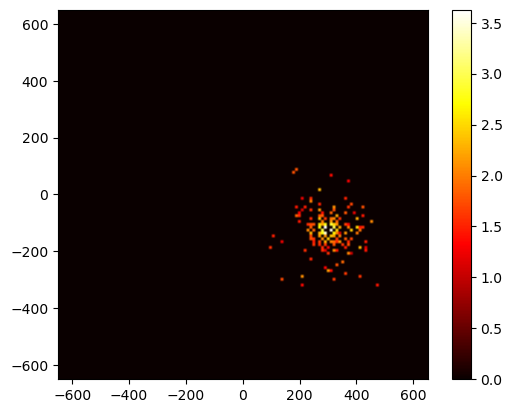

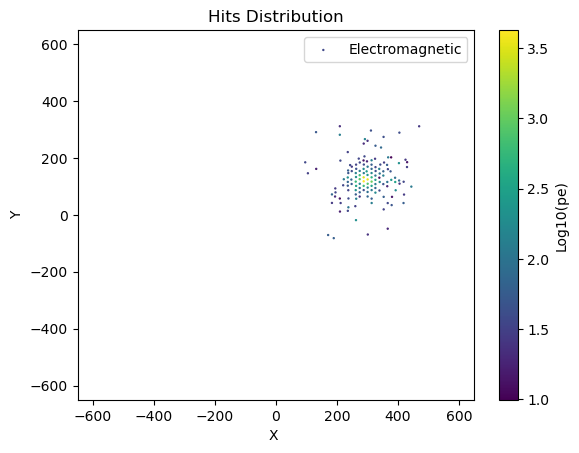

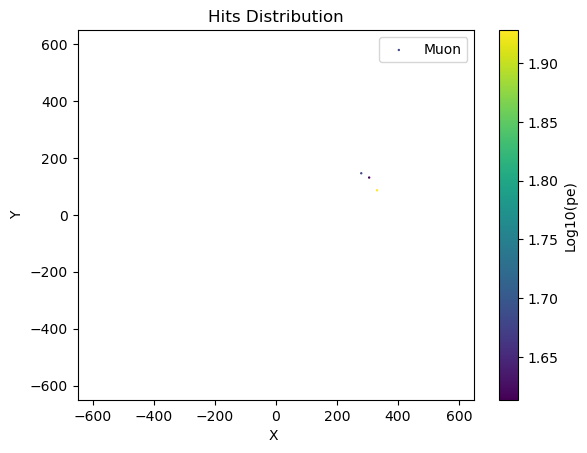

In [ ]:

# pre_loadDataset4Train(gamma_files,gamma_file_out,)
# pre_loadDataset4Train(proton_files,proton_file_out,)
# pre_loadDataset4Train(monopole_files,"/data/zhonghua/Dataset_Filted/ForTrain/Monopole_combined_filted_1e9_V03_dataset.npz",)

sample_num=[60000,60000,-1]
outputfile="/data/zhonghua/Dataset_Filted/ForTrain/combined_filted_1e10_V03_dataset.npz"

data = np.load(outputfile, allow_pickle=True)
n=-1
hitsE = data['hitsE'][n]
hitsM = data['hitsM'][n]
labels = data['labels'][n]
print(f"Event {n}, label: {labels}")
ED_hits = hits_to_image(hitsE, hitsM, grid_size=128, only_ED=True)
plt.imshow(np.log10(ED_hits[0]+1), cmap='hot', extent=(-650, 650, -650, 650))
plt.colorbar()
plt.show()


plt.scatter(hitsE[:,0], hitsE[:,1], c=np.log10(hitsE[:,2]), s=0.5, label='Electromagnetic')
plt.xlim(-650, 650)
plt.ylim(-650, 650)
plt.colorbar(label='Log10(pe)')
plt.title('Hits Distribution')
plt.xlabel('X ')
plt.ylabel('Y')
plt.legend()
plt.show()
plt.scatter(hitsM[:,0], hitsM[:,1], c=np.log10(hitsM[:,2]), s=0.5, label='Muon')
plt.xlim(-650, 650)
plt.ylim(-650, 650)
plt.colorbar(label='Log10(pe)')
plt.title('Hits Distribution')
plt.xlabel('X ')
plt.ylabel('Y')
plt.legend()
plt.show()